In [15]:
!pip install --quiet cornac==1.15.4

In [16]:
import os
import sys
import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

%matplotlib inline


#Data exploration

In [17]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
df = pd.DataFrame(data, columns = ["user_id", "item_id", "rating"])
df.head(10)

,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0
5,298,474,4.0
6,115,265,2.0
7,253,465,5.0
8,305,451,3.0
9,6,86,3.0


In [18]:
print(f"Number of ratings: {len(df)}")
print(f"Number of users: {df.user_id.nunique()}")
print(f"Number of items: {df.item_id.nunique()}")

Number of ratings: 100000
Number of users: 943
Number of items: 1682


##Rating statistics

In [19]:
df.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

The 1st figure shows a histogram of frequency of each rating.
The 2nd describe in the form of box plot

<Axes: xlabel='rating'>

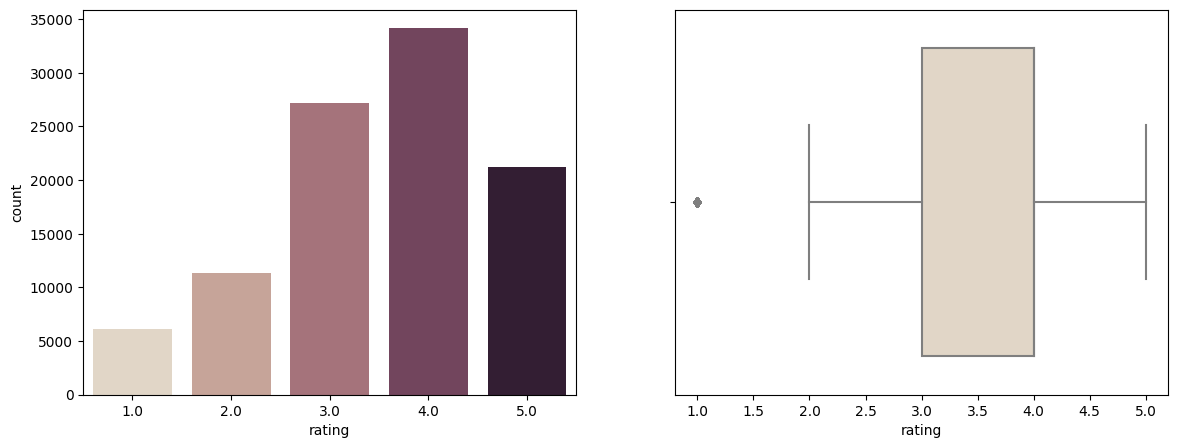

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data = df, palette="ch:.25", ax=axes[1])

##Data sparsity

In [21]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
SPARSITY: 93.70%


##Power_Law Distribution/Long-tailed distribution

Top 10 rated items

In [22]:
item_rate_count = df.groupby("item_id")["user_id"].nunique().sort_values(ascending = False)
item_rate_count.head(10)

item_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: user_id, dtype: int64

List of 10 least rated items

In [23]:
item_rate_count.tail(10)

item_id
1580    1
1581    1
1582    1
1583    1
1584    1
1586    1
1587    1
1363    1
1364    1
1604    1
Name: user_id, dtype: int64

The figure shows the number of ratings of each item and the figure show the relationship between the number of ratings and the number of items (in log scale).

[Text(0.5, 1.0, 'log-log plot'),
 Text(0.5, 0, 'rating (log scale)'),
 Text(0, 0.5, 'item (log scale)')]

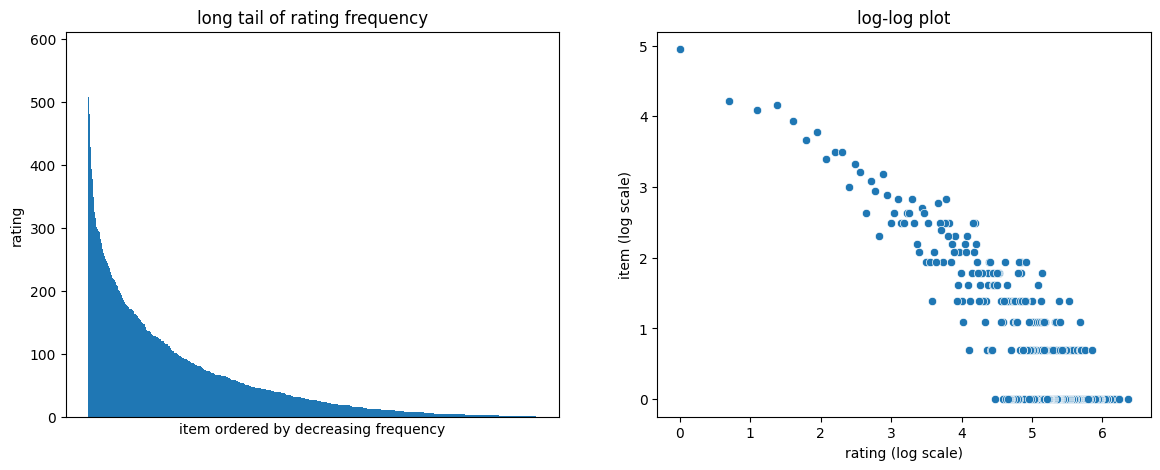

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=item_rate_count.index, height = item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", xlabel="item ordered by decreasing frequency", 
            ylabel="rating")
count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="rating (log scale)", ylabel="item (log scale)")

#Recommendation Based on Item Popularity

In [25]:
# 5-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(data, n_folds=5, seed=42)

#recommender system based on item popularity
most_pop = cornac.models.MostPop()

#recall@20 metric
rec_20 = cornac.metrics.Recall(k=20)

#put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run()



TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1263 |    0.0062 |   0.4874
Fold 1 |    0.1304 |    0.0063 |   0.5619
Fold 2 |    0.1337 |    0.0086 |   0.5996
Fold 3 |    0.1252 |    0.0088 |   0.6179
Fold 4 |    0.1187 |    0.0064 |   0.4154
------ + --------- + --------- + --------
Mean   |    0.1269 |    0.0073 |   0.5365
Std    |    0.0051 |    0.0012 |   0.0753

